In [1]:
# Preamble

from astropy.table import Table, column
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

# Load/edit the data

In [2]:
# load the data
gz_data = Table.read('../../fits/full_sample_debiased_w_low_z.fits')
nsa_data = Table.read('../../fits/NSA/nsa_v0_1_2.fits')

In [3]:
# SB: correction factor for the cosmology:
correction_factor = 2.5*np.log10(1**2/0.7**2)
nsa_data['M_corrected'] = nsa_data['ABSMAG'] - correction_factor

# Convert mass from Baldry et al. to Chabrier:
gz_data['mstar_baldry_chabrier'] = gz_data['LOGMSTAR_BALDRY06'] - 0.03

# Remove co-added depth images:
normal_depth = ['coadd' not in gz_data['sample'][i] for i in range(len(gz_data))]
normal_depth = np.array(normal_depth)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


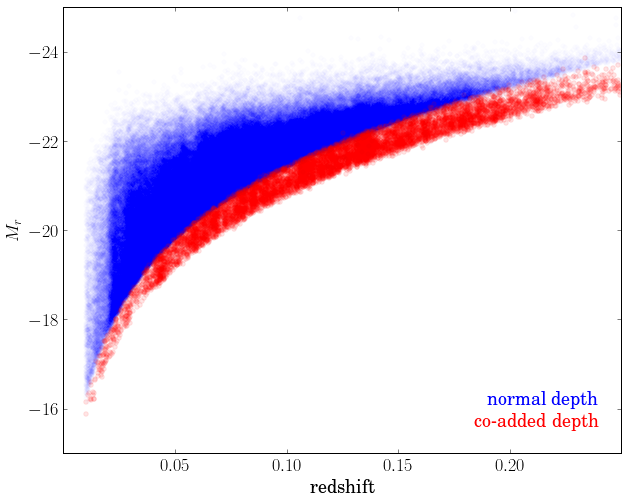

In [4]:
_ = plt.scatter(gz_data['REDSHIFT_1'][normal_depth], gz_data['PETROMAG_MR'][normal_depth]
                ,alpha=0.01,color='b',label='normal depth')

_ = plt.scatter(gz_data['REDSHIFT_1'][normal_depth == False], gz_data['PETROMAG_MR'][normal_depth == False]
                ,alpha=0.1,color='r',label='co-added depth')

plt.text(0.24,-16,'normal depth',ha='right',va='bottom',color='b')
plt.text(0.24,-15.5,'co-added depth',ha='right',va='bottom',color='r')

plt.axis((0,0.25,-15,-25))
plt.xlabel('redshift')
plt.ylabel(r'$M_r$')

# Match the data 
### 1) NASA Sloan Atlas

In [5]:
import sys
sys.path.append('../../astro_codes/')
#------------------------------------
import volume_limiting
from mass_limiting import get_mass_limit, baldry_equation
import combining_catalogues
import mass_limiting

In [6]:
matches = combining_catalogues.match_sky_restricted(gz_data,nsa_data,10,0.001
                                                    ,['ra_1','dec_1','REDSHIFT_1'],['RACAT','DECCAT','Z'])
# 10" match ^
nsa_matched = combining_catalogues.make_matched_catalogue(gz_data,nsa_data,matches)

248883 galaxies in the reference catalogue
145155 galaxies in the match catalogue
---> 145155 matches in total
---> 68630 unique matches of < 10 arcsec
---> 68423 unique matches of delta-z < 0.001


In [25]:
in_redshift = (nsa_matched['Z'] >= 0.02) & (normal_depth)
print('w. {} in the 0.02<z<0.055 range'.format(np.sum(in_redshift)))

w. 63100 in the 0.02<z<0.055 range


### 2) Chang+15 WISE data

In [8]:
# Load the WISE data:
chang_in = Table.read('../../fits/Chang_15/sw_input.fits')
chang_out = Table.read('../../fits/Chang_15/sw_output.fits')

In [9]:
def print_sample_size(mask,name):
    y = np.sum(mask)
    t = len(mask)
    print(name + ': {}/{} galaxies ({}%)'.format(y,t,np.round(100*y/t,decimals=1)))
#---------------------------

single_detection = chang_out['flag_w'] == 1
print_sample_size(single_detection,'Single optical')

ok_mass = (chang_out['flag_w1'] == 1) | (chang_out['flag_w2'] == 1)
print_sample_size(ok_mass,'Good W1/2 detection')

ok_wise = (single_detection) & (ok_mass)
print_sample_size(ok_wise,'Good overall detection')

chang_in_ok, chang_out_ok = [c[ok_wise] for c in [chang_in,chang_out]]

Single optical: 770900/858365 galaxies (89.8%)
Good W1/2 detection: 846433/858365 galaxies (98.6%)
Good overall detection: 770897/858365 galaxies (89.8%)


In [10]:
chang_matches = combining_catalogues.match_sky_restricted(gz_data,chang_in_ok,max_separation=6,max_dz=0.1,
                                                          reference_xyz=['RA', 'DEC', 'REDSHIFT_1'],
                                                          match_xyz=['ra', 'dec', 'redshift'])
# 7" match ^ (PSF of W1-3 is 6-7")

chang_in_matched = combining_catalogues.make_matched_catalogue(gz_data,chang_in_ok,chang_matches)
chang_out_matched = combining_catalogues.make_matched_catalogue(gz_data,chang_out_ok,chang_matches)

248883 galaxies in the reference catalogue
770897 galaxies in the match catalogue
---> 770897 matches in total
---> 193211 unique matches of < 6 arcsec
---> 193146 unique matches of delta-z < 0.1


In [11]:
in_wise = chang_out_matched['mask']
print('in WISE + in z: {}'.format(np.sum(in_wise*in_redshift)))
print(47026/63841)

in WISE + in z: 47026
0.736611268620479


### Check the correction for the $r$-band magnitudes

/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


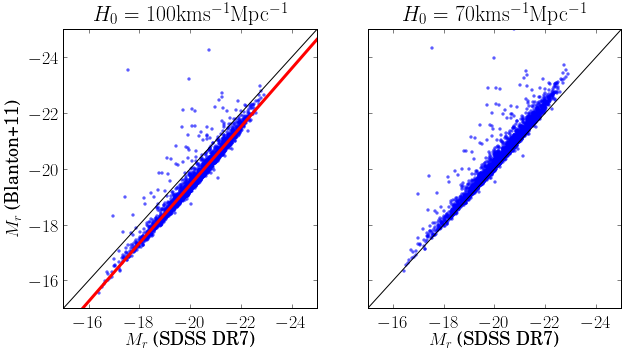

In [41]:
from scipy.optimize import curve_fit

def linear(x,m,c):
    return  m*x + c

def plot_subset(x,y,color='k',alpha=0.75,s=6,N=100,rasterized=True,zorder=0,label=None):
    np.random.seed(0)
    subset = np.append(np.ones(N),np.zeros(len(y)-N)).astype(bool) # select only N galaxies
    np.random.shuffle(subset)
    _ = plt.scatter(x[subset],y[subset],color=color,alpha=alpha,s=s,
                    zorder=zorder,rasterized=rasterized,label=label)
    return None

mask = nsa_matched['mask']

fig, axarr = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)
plt.sca(axarr[0])

x = gz_data['PETROMAG_MR'][mask]
y = nsa_matched['ABSMAG'][:,4][mask]
xy = np.array([x,y]).T
plot_subset(x,y,color='b',N=3000,alpha=0.5)
plt.plot([-25,-15],[-25,-15],'k')
plt.title('$H_0 = 100 \mathrm{kms^{-1}Mpc^{-1}}$')
plt.xlabel('$M_r$ (SDSS DR7)')
plt.ylabel('$M_r$ (Blanton+11)')

Mr_fit_paramaters, _ = curve_fit(linear,xy[:,0],xy[:,1])

x_guide = np.linspace(-15,-25,20)
_ = plt.plot(x_guide,linear(x_guide,*Mr_fit_paramaters),'r',lw=3)

#plt.text(-21,-19,'y={}x + {}'.format(np.round(Mr_fit_paramaters[0],decimals=2),
                                     #np.round(Mr_fit_paramaters[1],decimals=2)),
        #color='r',size=10)

plt.sca(axarr[1])
y = nsa_matched['M_corrected'][:,4][mask]
plot_subset(x,y,color='b',N=3000,alpha=0.5)
plt.plot([-25,-15],[-25,-15],'k')
plt.xlabel('$M_r$ (SDSS DR7)')
plt.title('$H_0 = 70 \mathrm{kms^{-1}Mpc^{-1}}$')
_ = plt.axis((-15,-25,-15,-25))

# Now create the samples

In [13]:
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
cosmo = FlatLambdaCDM(H0=70, Om0=0.3) # 737 cosmology

def mag_to_Mag(mag,z):
    D = cosmo.luminosity_distance(z).to(u.pc)
    Mag = mag - 5*(np.log10(D.value)-1)
    return Mag

# Guideline for absolute and apparent magnitudes:
z_guide = np.linspace(0,0.06,1000)
M_guide = mag_to_Mag(17,z_guide)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


## 1) Luminosity-limited sample:

Has WISE detection: 50659/248883 galaxies (20.4%)
z-limited: 47026/248883 galaxies (18.9%)
lum.-limited: 31931/248883 galaxies (12.8%)
M_r limit = -19.94933581259604


/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


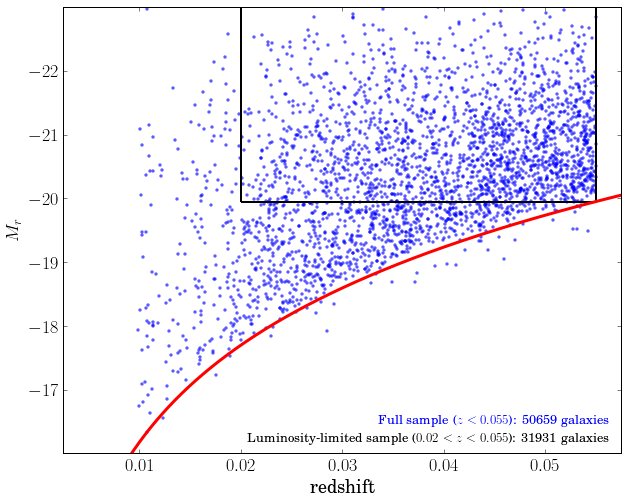

In [14]:
xlims = (0.0025,0.0575)
ylims = (-16,-23)
# Preamble
plt.figure(figsize=(10,8))
ax = plt.subplot(111)
_ = plt.axis((xlims[0],xlims[1],ylims[0],ylims[1]))
plt.xlabel('redshift')
plt.ylabel('$M_r$')

mag_limit = volume_limiting.get_sample_limits(0.055,17)

x = nsa_matched['Z'][mask]
y = nsa_matched['M_corrected'][:,4][mask]

plot_subset(x,y,color='b',N=3000,alpha=0.5)
plt.vlines(0.02,ylims[1],mag_limit,lw=2,zorder=1)
plt.hlines(mag_limit,0.02,0.055,lw=2,zorder=1)
plt.vlines(0.055,ylims[1],mag_limit,lw=2,zorder=1)
_ = plt.plot(z_guide,M_guide,color='r',lw=3,zorder=1)


wise_limited = (nsa_matched['mask'] > 0.02) & (chang_in_matched['mask'])
print_sample_size(wise_limited,'Has WISE detection')
#-------
redshift_limited = (nsa_matched['Z'] > 0.02) & (chang_in_matched['mask'])
print_sample_size(redshift_limited,'z-limited')
#-------
luminosity_limited = ((nsa_matched['Z'] >= 0.02) & 
                      (nsa_matched['M_corrected'][:,4] <= mag_limit) & 
                      (chang_in_matched['mask']))
print_sample_size(luminosity_limited,'lum.-limited')
#-------

_ = plt.text(0.98,0.06,'Full sample ($z < 0.055$): {} galaxies'.format(np.sum(wise_limited)),
             transform=ax.transAxes,ha='right',va='bottom',size=13,color='b')
_ = plt.text(0.98,0.02,'Luminosity-limited sample ($0.02 < z < 0.055$): {} galaxies'.format(np.sum(luminosity_limited)),
             transform=ax.transAxes,ha='right',va='bottom',size=13)

print('M_r limit = {}'.format(mag_limit))

## 2) Now an M* limited sample
### i) Baldry+2006 data

/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


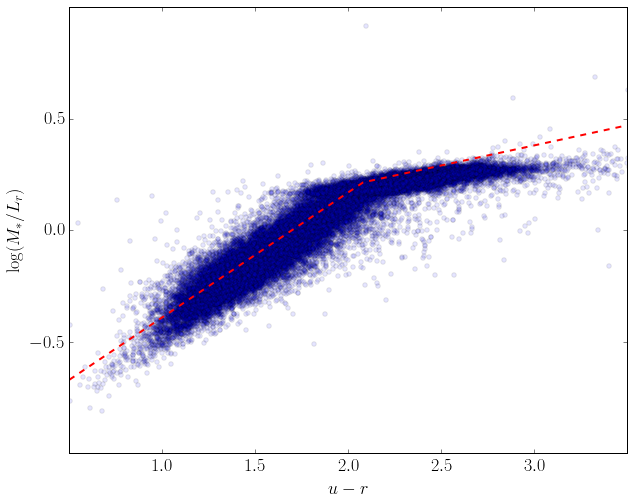

In [15]:
def Mag_to_lum(Mag,Mag_sun=4.75):
    L = 10**((Mag_sun-Mag)/2.5)
    return L

u_r = gz_data[redshift_limited]['PETROMAG_MU'] - gz_data[redshift_limited]['PETROMAG_MR'] # colour
ML = 10**(gz_data[redshift_limited]['LOGMSTAR_BALDRY06'])/Mag_to_lum(gz_data[redshift_limited]['PETROMAG_MR'])
logML = np.log10(ML) # mass-to-light ratio

_ = plt.scatter(u_r,logML,alpha=0.1)
_ = plt.axis((0.5,3.5,-1,1))
plt.xlabel('$u-r$')
plt.ylabel('$\log(M_*/L_r)$')

x_guide = np.linspace(0.5,3.5,1000)
y_baldry = []
for x in x_guide:
    y_baldry.append(baldry_equation(x))
y_baldry = np.array(y_baldry)
_ = plt.plot(x_guide,y_baldry,'r--',lw=2)
# red line = line suggested by Baldry+06

### ii) Attempt to recreate this for our dataset

In [16]:
mask = nsa_matched['mask']
print_sample_size(mask,'NSA matched')

mask = (nsa_matched['mask']) & (chang_in_matched['mask'])
print_sample_size(mask,'NSA + WISE matched')

NSA matched: 68423/248883 galaxies (27.5%)
NSA + WISE matched: 50659/248883 galaxies (20.4%)


In [17]:
redshift_limited = (nsa_matched['Z'] >= 0.02) & (normal_depth)
print_sample_size(redshift_limited,'z-limited')
#--------------
chang_out_zl = chang_out_matched[redshift_limited]
print_sample_size(chang_out_zl['mask'],'Has Chang mass (z-limited)')

mask = (redshift_limited) & (chang_out_matched['mask'])

z-limited: 63100/248883 galaxies (25.4%)
Has Chang mass (z-limited): 46319/63100 galaxies (73.4%)


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in power
  from ipykernel import kernelapp as app


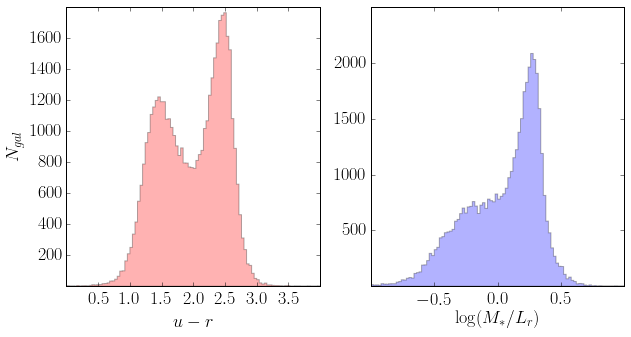

In [18]:
fig, axarr = plt.subplots(1,2,figsize=(10,5))

u_r = (nsa_matched['M_corrected'][:,2] - nsa_matched['M_corrected'][:,4])[mask]
logmass = chang_out_matched['lmass50_all'][mask]
logLr = np.log10(Mag_to_lum(nsa_matched['M_corrected'][:,4]))[mask]
logML = logmass - logLr

_ = axarr[0].hist(u_r,bins=np.linspace(0,4,101),histtype='stepfilled',color='r',alpha=0.3)
_ = axarr[1].hist(logML,bins=np.linspace(-1,1,101),histtype='stepfilled',color='b',alpha=0.3)
axarr[0].set_ylabel('$N_{gal}$')
axarr[0].set_xlabel('$u-r$')
axarr[1].set_xlabel('$\log(M_*/L_r)$')

sample_ok = ((u_r >= 0.5) & (u_r <= 3.5) 
             & (logML >= -1) & (logML <= 1))

In [19]:
from scipy.stats import binned_statistic
from astroML.resample import bootstrap

def plot_line(x,y,bins=12,plot=True,fill=False,color='k',ranges=None,use_bootstrap=False,
              percentile=1):
    
    def percentiles(x):
        lower = np.percentile(x,percentile)
        median = np.median(x)
        upper = np.percentile(x,100-percentile)
        return lower, median, upper
    
    if ranges == None:
        ranges = (np.min(x),np.max(x),np.min(y),np.max(y))
        
    if isinstance(bins, int) == True:
        bins = np.linspace(ranges[0],ranges[1],bins+1)
    x_bins, _, bin_assignment = binned_statistic(x,x,bins=bins,statistic='median')
    
    x_medians = np.array([])
    x_uppers = np.array([])
    x_lowers = np.array([])
    y_medians = np.array([])
    y_uppers = np.array([])
    y_lowers = np.array([])
    for b in np.unique(bin_assignment):
        in_bin = bin_assignment == b
        x_bin = x[in_bin]
        y_bin = y[in_bin]
        
        if use_bootstrap == True:
            x_lower, x_median, x_upper = bootstrap(x_bin,10,percentiles,random_state=0)
            y_lower, y_median, y_upper = bootstrap(y_bin,10,percentiles,random_state=0)
        else:
            x_lower, x_median, x_upper = percentiles(x_bin)
            y_lower, y_median, y_upper = percentiles(y_bin)
        
        x_lowers = np.append(x_lowers,x_lower)
        x_medians = np.append(x_medians,x_median)
        x_uppers = np.append(x_uppers,x_upper)
        y_lowers = np.append(y_lowers,y_lower)
        y_medians = np.append(y_medians,y_median)
        y_uppers = np.append(y_uppers,y_upper)
    
    if plot == True:
        _ = plt.plot(x_medians, y_medians,color=color,lw=3)
        if fill == True:
            _ = plt.fill_between(x_medians,y_lowers,y_uppers,color=color,alpha=0.4)
        else:
            _ = plt.plot(x_medians,y_lowers,linestyle='dashed',linewidth=2,color=color)
            _ = plt.plot(x_medians,y_uppers,linestyle='dashed',linewidth=2,color=color)
            
    stats_table = Table()
    stats_table['x'] = x_medians
    stats_table['x_upper'] = x_uppers
    stats_table['x_lower'] = x_lowers
    stats_table['y'] = y_medians
    stats_table['y_upper'] = y_uppers
    stats_table['y_lower'] = y_lowers
    
    return stats_table, bins

from palettable.colorbrewer.sequential import Greys_9

def heatmap(x,y,x_bins,y_bins,colormap,colorbar=True,log_scale=False,
            xlabel='x',ylabel='y',zlabel='z'):
    if log_scale == True:
        h = plt.hist2d(x,y,bins=[x_bins,y_bins],
                       norm=mpl.colors.LogNorm(),cmap=colormap)
    else:
        h = plt.hist2d(x,y,bins=[x_bins,y_bins],cmap=colormap)
    if colorbar == True:
        cbar = plt.colorbar()
        cbar.set_label(zlabel,rotation=270)
        cbar.ax.get_yaxis().labelpad = 20
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    return h

y=0.5268943005077399x + -1.3593931520948843


/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


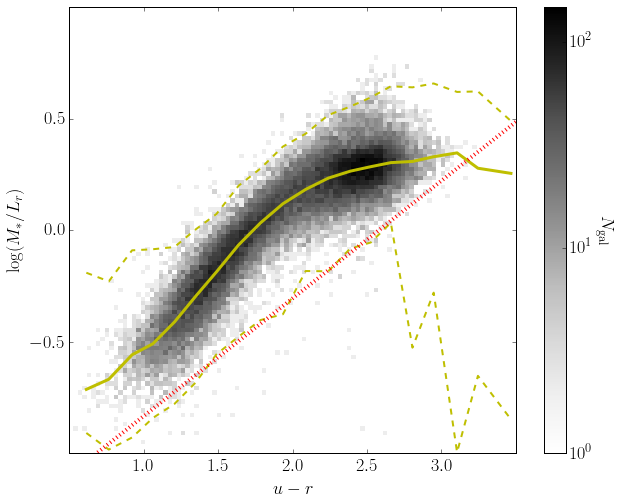

In [20]:
from scipy.optimize import curve_fit

xlims = (0.5,3.5)
ylims = (-1,1)
xlabel = '$u-r$'
ylabel = '$\log(M_*/L_r)$'
zlabel = '$N_\mathrm{gal}$'

fig = plt.figure(figsize=(10,8))
_ = plt.axis((xlims[0],xlims[1],ylims[0],ylims[1]))

#_ = plt.scatter(u_r[sample_ok],logML[sample_ok],alpha=0.1,color='g')
x = u_r[sample_ok]
y = logML[sample_ok]
x_bins = np.linspace(xlims[0],xlims[1],101)
y_bins = np.linspace(ylims[0],ylims[1],101)
_ = heatmap(x,y,x_bins,y_bins,Greys_9.mpl_colormap,log_scale=True,
            xlabel=xlabel,ylabel=ylabel,zlabel=zlabel)

stats_table, ur_bins = plot_line(u_r[sample_ok],logML[sample_ok],bins=20,color='y',use_bootstrap=True)
x_median = stats_table['x']
y_lower = stats_table['y_lower']

from scipy.optimize import curve_fit

def quadratic(x,a,b,c):
    return a*x**2 + b*x + c

def linear(x,m,c):
    return m*x + c

p,_ = curve_fit(linear,x_median[:-6],y_lower[:-6])
xg = np.linspace(xlims[0],xlims[1],1000)
_ = plt.plot(xg,linear(xg,*p),'r:',lw=4)
print('y={}x + {}'.format(p[0],p[1]))

def mass_func(x):
    return linear(x,*p)
#plt.savefig('output_figures/colour_vs_ML.pdf')

In [21]:
has_mass = chang_out_matched['mask']
mask =  (has_mass) & (nsa_matched['mask'])
print_sample_size(mask,'WISE+z-limited')
nsa_w_mass = nsa_matched[mask]

nsa_w_mass['M_u'] = nsa_w_mass['M_corrected'][:,2]
nsa_w_mass['M_r'] = nsa_w_mass['M_corrected'][:,4]
chang_out_w_mass = chang_out_matched[mask]

mass_limit_max = get_mass_limit(nsa_w_mass,z_limit=0.055,mag_limit=17,mass_equation=mass_func,
                                column_names=['Z','M_r'],colours=['M_u','M_r'])

WISE+z-limited: 50659/248883 galaxies (20.4%)


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


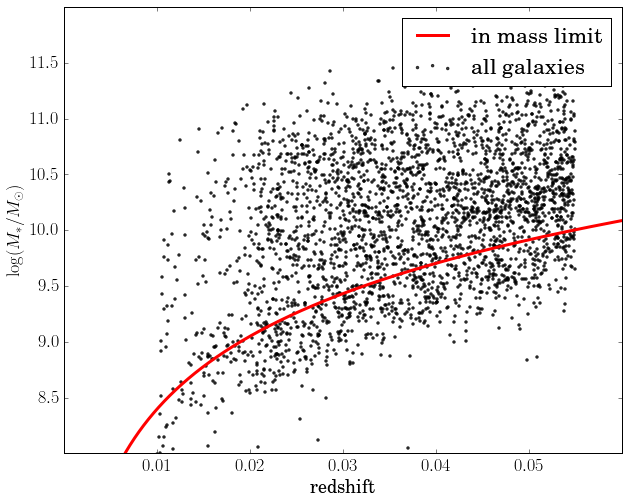

In [22]:
# calculate the mass limit for a given redshift limit

z_values = np.linspace(0.021,0.055,101)
mass_limits = []

for z in z_values:
    mass_limit = get_mass_limit(nsa_w_mass,z_limit=z,mag_limit=17,mass_equation=mass_func,
                                column_names=['Z','M_r'],colours=['M_u','M_r'])
    mass_limits.append(mass_limit)  
mass_limits = np.array(mass_limits)

def log_function(x,a,b):
    return a*np.log10(x) + b

p_mass_limit, _ = curve_fit(log_function,z_values,mass_limits)

x = nsa_w_mass['Z']
y = chang_out_w_mass['lmass50_all']

plot_subset(x,y,color='k',N=3000,label='all galaxies')
plt.axis((0,0.06,8,12))
x_guide = np.linspace(0,0.06,1000)
_ = plt.plot(x_guide,log_function(x_guide,*p_mass_limit),color='r',lw=3,label='in mass limit')
plt.xlabel('redshift')
plt.ylabel('$\log (M_*/M_\odot)$')
_ = plt.legend()

In [23]:
print('Absolute_magnitude limit: M_r < {}'.format(mag_limit))
print('M* limit: M* > {}'.format(mass_limit_max))
print('mass limit equation params:',p_mass_limit)

Absolute_magnitude limit: M_r < -19.94933581259604
M* limit: M* > 10.010059403725307
mass limit equation params: [  2.17448693  12.74227225]


## Now define a table with all of the required masks:
### Various mass/lum. limits

In [27]:
samples = Table()

samples['in_nsa'] = nsa_matched['mask']
print_sample_size(samples['in_nsa'],'in NSA')

samples['in_wise'] = chang_out_matched['mask']
print_sample_size(samples['in_wise'],'in WISE')

samples['in_redshift'] = (nsa_matched['Z'] >= 0.02) & (samples['in_wise']) & (normal_depth)
print_sample_size(samples['in_redshift'],'NSA+WISE in z-limit')

samples['in_lum_limit'] = (samples['in_redshift']) & (nsa_matched['M_corrected'][:,4] <= mag_limit)
print_sample_size(samples['in_lum_limit'],'Lum.-limited sample')

samples['in_mass_limit'] = (samples['in_lum_limit']) & (chang_out_matched['lmass50_all'] >= mass_limit)
print_sample_size(samples['in_mass_limit'],'M*.-limited sample')

samples['in_vmax_limit'] = (samples['in_redshift']) & (chang_out_matched['lmass50_all'] >= log_function(nsa_matched['Z'],*p_mass_limit))
print_sample_size(samples['in_vmax_limit'],'Vmax-limited sample')

in NSA: 68423/248883 galaxies (27.5%)
in WISE: 193146/248883 galaxies (77.6%)
NSA+WISE in z-limit: 46319/248883 galaxies (18.6%)
Lum.-limited sample: 31894/248883 galaxies (12.8%)
M*.-limited sample: 25759/248883 galaxies (10.3%)
Vmax-limited sample: 35788/248883 galaxies (14.4%)


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in log10
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in greater_equal


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


46319 46319 46319
46319 46319 46319


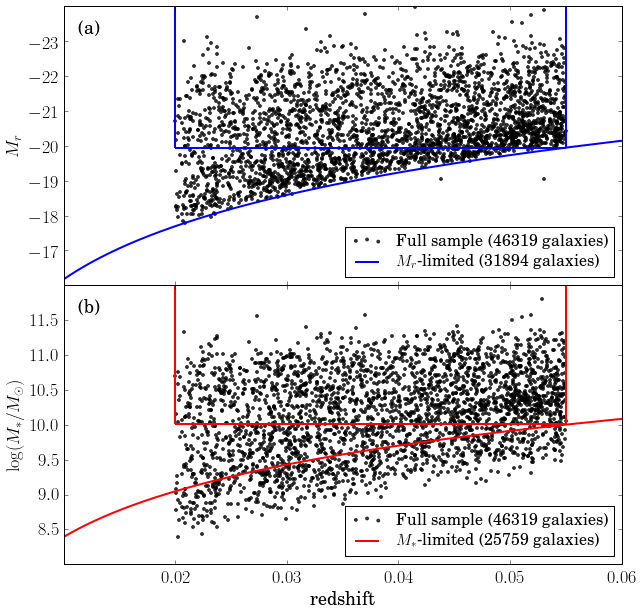

In [48]:
fig, axarr = plt.subplots(2,1,figsize=(10,10),sharex=True)
axarr[1].set_xlabel('redshift')
plt.subplots_adjust(hspace=0,wspace=0)

z_guide = np.linspace(0,0.06,1000)
M_guide = mag_to_Mag(17,z_guide)
mass_guide = log_function(z_guide,*p_mass_limit)

def box(xlimits,ylimit,color='k',linestyle='solid',linewidth=2,zorder=0,
        label=None):

    xmin, xmax, ymin, ymax = plt.axis()
    plt.vlines(xlimits[0],ylimit,ymax,zorder=zorder,label=label,
               color=color,linestyle=linestyle,linewidth=linewidth)
    plt.hlines(ylimit,xlimits[0],xlimits[1],zorder=zorder,
               color=color,linestyle=linestyle,linewidth=linewidth)
    plt.vlines(xlimits[1],ylimit,ymax,zorder=zorder,
               color=color,linestyle=linestyle,linewidth=linewidth)
    return None


def plot_subset(x,y,color='k',alpha=0.75,s=6,N=100,rasterized=True,zorder=0,label=None):
    np.random.seed(0)
    subset = np.append(np.ones(N),np.zeros(len(y)-N)).astype(bool) # select only N galaxies
    print(len(x),len(y),len(subset))
    np.random.shuffle(subset)
    _ = plt.scatter(x[subset],y[subset],color=color,alpha=alpha,s=s,
                    zorder=zorder,rasterized=rasterized,label=label)
    return None

lw = 2
lw2 = 2

plt.sca(axarr[0])
x = nsa_matched['Z'][samples['in_redshift']]
y = nsa_matched['M_corrected'][:,4][samples['in_redshift']]
plot_subset(x,y,N=3000,color='k',s=8,zorder=-1,
            label='Full sample ({} galaxies)'.format(np.sum(samples['in_redshift'])))
plt.plot(z_guide,M_guide,lw=lw2,color='b',zorder=0)
_ = plt.axis((0,0.06,-16,-24))
box([0.02,0.055],mag_limit,color='b',linewidth=lw,
    label='$M_r$-limited ({} galaxies)'.format(np.sum(samples['in_lum_limit']*samples['in_wise'])))
plt.ylabel('$M_r$')
plt.legend(loc='lower right',fontsize=16)
plt.text(0.025,0.95,'(a)',
         transform=axarr[0].transAxes,ha='left',va='top')

plt.sca(axarr[1])
y = chang_out_matched['lmass50_all'][samples['in_redshift']]
plot_subset(x,y,N=3000,color='k',s=8,zorder=-1,
            label='Full sample ({} galaxies)'.format(np.sum(samples['in_redshift'])))
plt.plot(z_guide,mass_guide,lw=lw2,color='r',zorder=0)
box([0.02,0.055],mass_limit,color='r',linewidth=lw,
    label='$M_*$-limited ({} galaxies)'.format(np.sum(samples['in_mass_limit'])))
plt.ylabel('$\log(M_*/M_\odot)$')
plt.legend(loc='lower right',fontsize=16)
plt.text(0.025,0.95,'(b)',
         transform=axarr[1].transAxes,ha='left',va='top')
_ = plt.axis((0.01,0.06,8,12))

plt.savefig('output_figures/samples.pdf')

### Get the spirals

In [29]:
# get spirals:
import make_dictionaries
questions = make_dictionaries.questions

p_spiral = (gz_data['t01_smooth_or_features_a02_features_or_disk_debiased_rh']*
            gz_data['t02_edgeon_a05_no_debiased_rh']*
            gz_data['t04_spiral_a08_spiral_debiased_rh'])

N_spiral = (gz_data['t04_spiral_a08_spiral_count'] - 
            gz_data['t11_arms_number_a37_cant_tell_count'])

p_ok = p_spiral > 0.5
N_ok = N_spiral >= 5
in_spiral = (p_ok) & (N_ok)

question = 't11_arms_number'
answers = questions[question]['answers'][:-1]
answer_array = np.array([gz_data[question + '_' + A + '_debiased_rh'].data for A in answers]).T
m = np.argmax(answer_array,axis=1)

samples['in_spiral'] = in_spiral
samples['m'] = m

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater


In [30]:
# check axial ratios
ba_data = Table.read('../../fits/Axial_ratios/matched_axial_ratios.fits')
print('+ loaded axial data.')

axial_ok = ba_data['isoB_g']/ba_data['isoA_g'] > 0.4
samples['axial_ok'] = axial_ok

+ loaded axial data.


In [31]:
print('full sample: {} ({} spirals)'.format(np.sum((samples['in_wise']) & (samples['in_nsa'])),
                                            np.sum((samples['in_wise']) & (samples['in_nsa']) 
                                                   & (samples['in_spiral']) & (samples['axial_ok']))))

for s in samples.colnames[2:-2]:
    print('{}: {} galaxies ({} spirals)'.format(s, np.sum(samples[s]),
                                                np.sum((samples[s]) 
                                                       & (samples['in_spiral'])
                                                       & (samples['axial_ok']))))

full sample: 50659 (10912 spirals)
in_redshift: 46319 galaxies (10140 spirals)
in_lum_limit: 31894 galaxies (8950 spirals)
in_mass_limit: 25759 galaxies (6454 spirals)
in_vmax_limit: 35788 galaxies (8248 spirals)
in_spiral: 50857 galaxies (48015 spirals)


In [32]:
# For each galaxy, calculate its 'mass weighting'

def inverse_mass_function(mass,mass_error,a,b):
    zmax = 10**((mass-b)/a)
    zmax_error = (zmax/a)*mass_error
    return zmax, zmax_error

def get_mass_weighting(mass,mass_error,max_z=0.055,min_z=0.02):
    zmax,z_error = inverse_mass_function(mass,mass_error,*p_mass_limit)
    zmax[mass < 0] = -999
    zmax[zmax >= max_z] = max_z
    mass_weighting = (1/(zmax**3-min_z**3))/(1/(max_z**3-min_z**3))
    return zmax, mass_weighting, z_error

In [33]:
in_vmax_limit = samples['in_vmax_limit']

masses = chang_out_matched[in_vmax_limit]['lmass50_all']
mass_errors = (chang_out_matched[in_vmax_limit]['lmass84_all']-chang_out_matched[in_vmax_limit]['lmass16_all'])/2

zmax, mass_weighting, z_error = get_mass_weighting(masses, mass_errors)
z = nsa_matched[in_vmax_limit]['Z']

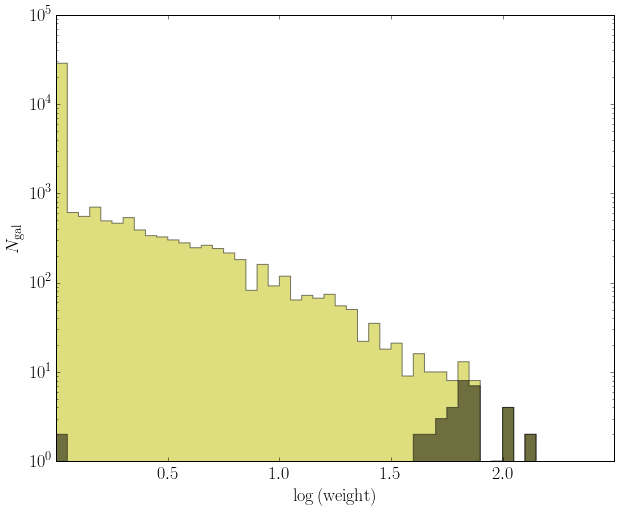

In [34]:
bad_z = 2*z_error > (zmax-0.02)

_ = plt.hist(np.log10(mass_weighting),histtype='stepfilled',
             color='y',alpha=0.5,bins=np.linspace(0,2.2,45))

_ = plt.hist(np.log10(mass_weighting[bad_z]),histtype='stepfilled',
             color='k',alpha=0.5,bins=np.linspace(0,2.2,45))

mass_weighting_good = mass_weighting.copy()
mass_weighting_good[bad_z] = 0

plt.yscale('log')
plt.xlabel('$\log\mathrm{(weight)}$')
plt.ylabel('$N_\mathrm{gal}$')

In [35]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.grid_search import GridSearchCV

def fit_ridgeline(x,y,alphas=np.logspace(-2,2,10),gammas=np.logspace(-2, 2, 10),
                  N_folds=3,N_max=1000):
    
    np.random.seed(0)
    N = len(x)
    
    if len(x) > N_max:
        subset = np.append(np.ones(N_max),np.zeros(N-N_max)).astype(bool) # select only N galaxies
        np.random.shuffle(subset)
    else:
        subset = np.ones(N).astype(bool)
    
    x_fit = x[subset][:,np.newaxis]
    y_fit = y[subset][:,np.newaxis]
    kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1), cv=N_folds,
                      param_grid={"alpha":alphas,"gamma":gammas})
    kr = kr.fit(x_fit,y_fit)
    
    return kr

In [36]:
mass_weights = np.zeros(len(samples))
mass_weights[in_vmax_limit] = mass_weighting_good
samples['mass_weighting'] = mass_weights
samples['in_vmax_limit'][samples['mass_weighting'] == 0] = 0

### Finally, save the required data for later use:

In [37]:
#gz_data.write('matched_fits/gz_data.fits',overwrite=True)
#nsa_matched.write('matched_fits/nsa_matched.fits',overwrite=True)
#chang_out_matched.write('matched_fits/chang_out_matched.fits',overwrite=True)
#chang_in_matched.write('matched_fits/chang_in_matched.fits',overwrite=True)
samples.write('matched_fits/samples.fits',overwrite=True)
#ba_data.write('matched_fits/ba_matched.fits',overwrite=True)